# AdventureWorks: Análisis de Ventas por Subcategoría y Territorio

Este cuaderno construye un análisis reproducible que conecta a PostgreSQL (AdventureWorks), explora tablas clave y calcula KPIs y visualizaciones para decisiones comerciales por Subcategoría de Producto y Territorio de Ventas.

In [30]:
# Imports y configuración
import os
import json
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text

# Opciones de visualización
pd.set_option('display.float_format', lambda x: f"{x:,.2f}")
sns.set(style='whitegrid', palette='Set2')
plt.rcParams['figure.figsize'] = (10, 6)


In [31]:
# Cargar variables de entorno (.env)
from dotenv import load_dotenv
_ = load_dotenv(dotenv_path=Path('.') / '.env')

PG_USER = os.getenv('PG_USER')
PG_PASSWORD = os.getenv('PG_PASSWORD')
PG_HOST = os.getenv('PG_HOST', 'localhost')
PG_PORT = os.getenv('PG_PORT', '5432')
PG_DB = os.getenv('PG_DB')

assert PG_USER and PG_PASSWORD and PG_DB, "Faltan variables de entorno para la conexión (PG_USER, PG_PASSWORD, PG_DB)."

In [32]:
# Conexión a PostgreSQL (SQLAlchemy) con tolerancia a mayúsculas/minúsculas en el nombre de DB
candidates = [PG_DB]
if PG_DB:
    low = PG_DB.lower()
    title = low.title()
    candidates = [PG_DB, low, title]

engine = None
last_err = None
for db in dict.fromkeys(candidates):  # de-duplicar conservando orden
    try:
        conn_str = f"postgresql+psycopg2://{PG_USER}:{PG_PASSWORD}@{PG_HOST}:{PG_PORT}/{db}"
        engine = create_engine(conn_str, pool_pre_ping=True)
        with engine.connect() as con:
            con.execute(text("SELECT 1"))
        print(f"Conectado a DB='{db}'")
        break
    except Exception as e:
        last_err = e
        engine = None

if engine is None:
    raise RuntimeError(f"No fue posible conectar a PostgreSQL con las variantes de DB {candidates}. Último error: {last_err}")

Conectado a DB='AdventureWorks'


In [33]:
# Verificación rápida de carga de datos: conteo de filas en tablas clave (minúsculas sin comillas)
rowcount_sql = {
    'sales.salesorderheader': 'SELECT COUNT(*) FROM sales.salesorderheader',
    'sales.salesorderdetail': 'SELECT COUNT(*) FROM sales.salesorderdetail',
    'production.product': 'SELECT COUNT(*) FROM production.product',
    'production.productsubcategory': 'SELECT COUNT(*) FROM production.productsubcategory',
    'production.productcategory': 'SELECT COUNT(*) FROM production.productcategory',
    'sales.salesterritory': 'SELECT COUNT(*) FROM sales.salesterritory',
    'sales.customer': 'SELECT COUNT(*) FROM sales.customer'
}

rowcounts = {}
with engine.connect() as con:
    for name, q in rowcount_sql.items():
        rowcounts[name] = pd.read_sql(text(q), con).iloc[0,0]

pd.Series(rowcounts, name='rows').to_frame()

,rows
sales.salesorderheader,0
sales.salesorderdetail,0
production.product,0
production.productsubcategory,0
production.productcategory,0
sales.salesterritory,0
sales.customer,0


In [34]:
# Construir tabla de ventas detallada (nivel ítem)
sql_sales = text("""
SELECT 
  soh.salesorderid,
  soh.orderdate,
  soh.duedate,
  soh.shipdate,
  soh.customerid,
  soh.territoryid,
  soh.subtotal AS order_subtotal,
  soh.taxamt,
  soh.freight,
  soh.totaldue,
  sod.salesorderdetailid,
  sod.productid,
  sod.orderqty,
  sod.unitprice,
  sod.unitpricediscount,
  (sod.orderqty * sod.unitprice * (1 - sod.unitpricediscount)) AS line_total,
  p.name AS product_name,
  p.productsubcategoryid,
  p.listprice,
  p.standardcost,
  p.size,
  p.color,
  p.productnumber,
  p.sellstartdate,
  p.sellenddate,
  p.discontinueddate,
  ps.name AS subcategory_name,
  pc.productcategoryid,
  pc.name AS category_name,
  st.name AS territory_name,
  st."group" AS territory_group
FROM sales.salesorderheader AS soh
JOIN sales.salesorderdetail AS sod
  ON soh.salesorderid = sod.salesorderid
JOIN production.product AS p
  ON sod.productid = p.productid
LEFT JOIN production.productsubcategory AS ps
  ON p.productsubcategoryid = ps.productsubcategoryid
LEFT JOIN production.productcategory AS pc
  ON ps.productcategoryid = pc.productcategoryid
LEFT JOIN sales.salesterritory AS st
  ON soh.territoryid = st.territoryid
""")

with engine.connect() as con:
    sales_df = pd.read_sql(sql_sales, con, parse_dates=['orderdate','duedate','shipdate','sellstartdate','sellenddate','discontinueddate'])

sales_df.head()

,salesorderid,orderdate,duedate,shipdate,customerid,territoryid,order_subtotal,taxamt,freight,totaldue,...,color,productnumber,sellstartdate,sellenddate,discontinueddate,subcategory_name,productcategoryid,category_name,territory_name,territory_group


In [35]:
# Agregados clave por Territorio, Subcategoría, Producto y Cliente

if 'sales_df' not in globals() or sales_df is None or sales_df.empty:
    print('sales_df está vacío. Carga datos en la BD y vuelve a ejecutar. (Ver celda de conteo de filas)')
    agg_territory_subcat = pd.DataFrame()
    agg_product = pd.DataFrame()
    orders = pd.DataFrame()
    customers = pd.DataFrame()
else:
    # Ventas por Territorio y Subcategoría
    agg_territory_subcat = (
        sales_df
        .groupby(['territory_name','subcategory_name'], dropna=False)
        .agg(ventas_monto=('line_total','sum'),
             pedidos=('salesorderid','nunique'),
             items=('salesorderdetailid','count'))
        .reset_index()
        .sort_values(['ventas_monto'], ascending=False)
    )

    # Ventas por Producto
    agg_product = (
        sales_df
        .groupby(['productid','product_name'], dropna=False)
        .agg(ventas_monto=('line_total','sum'),
             cantidad=('orderqty','sum'))
        .reset_index()
        .sort_values('ventas_monto', ascending=False)
    )

    # Gastos por Pedido (SubTotal a nivel pedido)
    orders = (
        sales_df[['salesorderid','customerid','orderdate','order_subtotal']]
        .drop_duplicates()
        .rename(columns={'salesorderid':'order_id','customerid':'customer_id'})
    )

    # Gastos por Cliente
    customers = (
        orders
        .groupby('customer_id')
        .agg(total_gasto=('order_subtotal','sum'),
             pedidos=('order_id','nunique'))
        .reset_index()
    )

agg_territory_subcat.head(), agg_product.head(), orders.head(), customers.head()

sales_df está vacío. Carga datos en la BD y vuelve a ejecutar. (Ver celda de conteo de filas)


(Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [])

In [36]:
# KPIs de tendencia central y dispersión del gasto

if orders is None or orders.empty:
    print('No hay pedidos (orders) para calcular KPIs. Asegura cargar datos y construir sales_df/aggregados.')
    central_disp_order = {}
    central_disp_customer = {}
else:
    # Por pedido
    order_spend = orders['order_subtotal']
    central_disp_order = {
        'media': order_spend.mean(),
        'mediana': order_spend.median(),
        'moda': float(order_spend.mode().iloc[0]) if not order_spend.mode().empty else np.nan,
        'varianza': order_spend.var(ddof=1) if len(order_spend) > 1 else np.nan,
        'desv_std': order_spend.std(ddof=1) if len(order_spend) > 1 else np.nan,
        'IQR': order_spend.quantile(0.75) - order_spend.quantile(0.25)
    }

    # Por cliente (gasto total acumulado)
    if customers is None or customers.empty:
        central_disp_customer = {}
    else:
        cust_spend = customers['total_gasto']
        central_disp_customer = {
            'media': cust_spend.mean(),
            'mediana': cust_spend.median(),
            'moda': float(cust_spend.mode().iloc[0]) if not cust_spend.mode().empty else np.nan,
            'varianza': cust_spend.var(ddof=1) if len(cust_spend) > 1 else np.nan,
            'desv_std': cust_spend.std(ddof=1) if len(cust_spend) > 1 else np.nan,
            'IQR': cust_spend.quantile(0.75) - cust_spend.quantile(0.25)
        }

central_disp_order, central_disp_customer

No hay pedidos (orders) para calcular KPIs. Asegura cargar datos y construir sales_df/aggregados.


({}, {})

In [37]:
# KPIs de negocio

if orders is None or orders.empty:
    print('No hay datos de pedidos para KPIs de negocio. Carga datos y vuelve a ejecutar.')
    AOV_pedido = np.nan
    AOV_cliente_global = np.nan
    Top5_subcats = pd.DataFrame(columns=['subcategory_name','line_total'])
    Top5_productos_cantidad = pd.DataFrame(columns=['productid','product_name','orderqty'])
    Top5_productos_ingreso = pd.DataFrame(columns=['productid','product_name','line_total'])
    producto_mayor_varianza_precio = None
else:
    # Ticket Promedio (AOV) por pedido
    AOV_pedido = orders['order_subtotal'].mean()

    # Ticket Promedio por cliente (promedio de gasto por pedido por cliente)
    if customers is not None and not customers.empty:
        customers['AOV_cliente'] = customers['total_gasto'] / customers['pedidos'].replace(0, np.nan)
        AOV_cliente_global = customers['AOV_cliente'].mean()
    else:
        AOV_cliente_global = np.nan

    # Top 5 Subcategorías por ventas (monto)
    Top5_subcats = (
        sales_df.groupby('subcategory_name', dropna=False)['line_total']
        .sum()
        .sort_values(ascending=False)
        .head(5)
        .reset_index()
    ) if sales_df is not None and not sales_df.empty else pd.DataFrame(columns=['subcategory_name','line_total'])

    # Top 5 Productos por cantidad e ingreso
    Top5_productos_cantidad = (
        sales_df.groupby(['productid','product_name'], dropna=False)['orderqty']
        .sum().sort_values(ascending=False).head(5).reset_index()
    ) if sales_df is not None and not sales_df.empty else pd.DataFrame(columns=['productid','product_name','orderqty'])

    Top5_productos_ingreso = (
        sales_df.groupby(['productid','product_name'], dropna=False)['line_total']
        .sum().sort_values(ascending=False).head(5).reset_index()
    ) if sales_df is not None and not sales_df.empty else pd.DataFrame(columns=['productid','product_name','line_total'])

    # Producto con mayor variabilidad de precio unitario (si aplica)
    if sales_df is not None and not sales_df.empty:
        unitprice_stats = (
            sales_df.groupby(['productid','product_name'])['unitprice']
            .agg(['count','mean','std'])
            .reset_index()
        )
        unitprice_stats_var = unitprice_stats[unitprice_stats['count'] > 1].sort_values('std', ascending=False)
        producto_mayor_varianza_precio = unitprice_stats_var.iloc[0] if not unitprice_stats_var.empty else None
    else:
        producto_mayor_varianza_precio = None

{
    'AOV_pedido': AOV_pedido,
    'AOV_cliente_global': AOV_cliente_global,
    'Top5_subcats': Top5_subcats,
    'Top5_productos_cantidad': Top5_productos_cantidad,
    'Top5_productos_ingreso': Top5_productos_ingreso,
    'producto_mayor_varianza_precio': producto_mayor_varianza_precio
}

No hay datos de pedidos para KPIs de negocio. Carga datos y vuelve a ejecutar.


{'AOV_pedido': nan,
 'AOV_cliente_global': nan,
 'Top5_subcats': Empty DataFrame
 Columns: [subcategory_name, line_total]
 Index: [],
 'Top5_productos_cantidad': Empty DataFrame
 Columns: [productid, product_name, orderqty]
 Index: [],
 'Top5_productos_ingreso': Empty DataFrame
 Columns: [productid, product_name, line_total]
 Index: [],
 'producto_mayor_varianza_precio': None}

In [38]:
# Visualizaciones

no_data = (
    ('customers' not in globals()) or (customers is None) or customers.empty or ('total_gasto' not in customers.columns)
    or ('sales_df' not in globals()) or (sales_df is None) or sales_df.empty
)

if no_data:
    print('Sin datos suficientes para visualizar. Asegúrate de cargar datos y de haber ejecutado las celdas de agregados/KPIs. (customers.total_gasto y sales_df requeridos)')
else:
    # 1) Histograma del gasto total por cliente
    fig, ax = plt.subplots()
    sns.histplot(customers['total_gasto'], bins=30, kde=True, ax=ax)
    ax.set_title('Histograma: Gasto total por cliente')
    ax.set_xlabel('Gasto total (SubTotal acumulado)')
    plt.show()

    # 2) Boxplot de ventas por Subcategoría (line_total por ítem)
    fig, ax = plt.subplots(figsize=(12, 6))
    plot_df = sales_df.copy()
    plot_df['subcategory_name'] = plot_df['subcategory_name'].fillna('Sin Subcategoría')
    sns.boxplot(data=plot_df, x='subcategory_name', y='line_total', ax=ax, showfliers=False)
    ax.set_title('Boxplot: Ventas por Subcategoría (line_total por ítem)')
    ax.set_xlabel('Subcategoría')
    ax.set_ylabel('line_total')
    ax.tick_params(axis='x', rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # 3) Barras Top 5 Subcategorías por ventas (monto)
    if 'Top5_subcats' in globals() and Top5_subcats is not None and not Top5_subcats.empty:
        fig, ax = plt.subplots()
        sns.barplot(data=Top5_subcats, x='subcategory_name', y='line_total', ax=ax)
        ax.set_title('Top 5 Subcategorías por ventas (monto)')
        ax.set_xlabel('Subcategoría')
        ax.set_ylabel('Ventas (line_total)')
        ax.tick_params(axis='x', rotation=30, ha='right')
        plt.tight_layout()
        plt.show()
    else:
        print('Top5_subcats vacío; omitiendo gráfico de Top 5 Subcategorías.')

    # 4) Barras Top 5 Productos por ingreso y por cantidad
    if 'Top5_productos_ingreso' in globals() and Top5_productos_ingreso is not None and not Top5_productos_ingreso.empty:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        sns.barplot(data=Top5_productos_ingreso, y='product_name', x='line_total', ax=axes[0])
        axes[0].set_title('Top 5 Productos por ingreso')
        axes[0].set_xlabel('Ventas (line_total)')
        axes[0].set_ylabel('Producto')

        if 'Top5_productos_cantidad' in globals() and Top5_productos_cantidad is not None and not Top5_productos_cantidad.empty:
            sns.barplot(data=Top5_productos_cantidad, y='product_name', x='orderqty', ax=axes[1])
            axes[1].set_title('Top 5 Productos por cantidad')
            axes[1].set_xlabel('Cantidad vendida')
            axes[1].set_ylabel('Producto')
        else:
            axes[1].text(0.5, 0.5, 'Sin datos para Top 5 por cantidad', ha='center')
            axes[1].axis('off')
        plt.tight_layout()
        plt.show()
    else:
        print('Top5_productos_ingreso vacío; omitiendo gráficos de Top 5 productos.')

    # 5) (Opcional) Heatmap de ventas por Territorio y Subcategoría
    heat_df = (
        sales_df.assign(subcategory_name=lambda d: d['subcategory_name'].fillna('Sin Subcategoría'))
                 .groupby(['territory_name','subcategory_name'])['line_total']
                 .sum()
                 .reset_index()
    )
    if not heat_df.empty:
        pivot = heat_df.pivot_table(index='territory_name', columns='subcategory_name', values='line_total', fill_value=0)
        fig, ax = plt.subplots(figsize=(12, 6))
        sns.heatmap(pivot, cmap='Blues', ax=ax)
        ax.set_title('Heatmap: Ventas por Territorio y Subcategoría')
        ax.set_xlabel('Subcategoría')
        ax.set_ylabel('Territorio')
        plt.tight_layout()
        plt.show()
    else:
        print('Sin datos para heatmap de territorio vs subcategoría.')

Sin datos suficientes para visualizar. Asegúrate de cargar datos y de haber ejecutado las celdas de agregados/KPIs. (customers.total_gasto y sales_df requeridos)


KeyError: 'total_gasto'

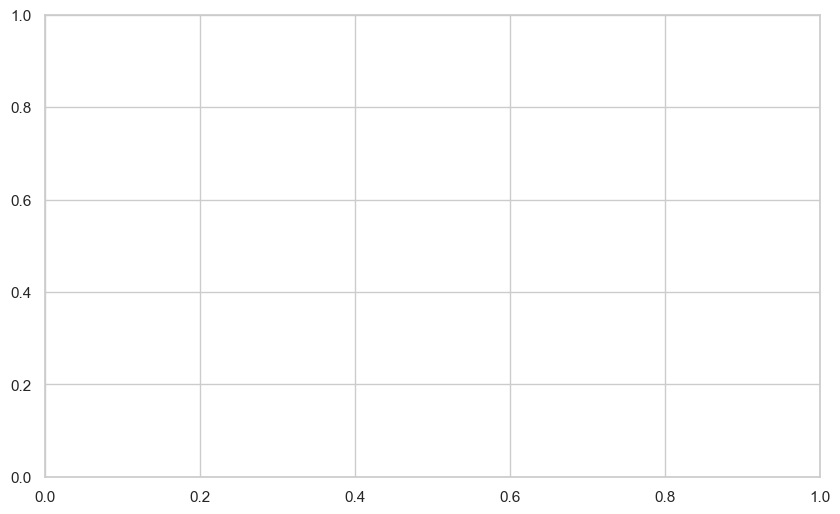

In [39]:
# Visualizaciones

# 1) Histograma del gasto total por cliente
fig, ax = plt.subplots()
sns.histplot(customers['total_gasto'], bins=30, kde=True, ax=ax)
ax.set_title('Histograma: Gasto total por cliente')
ax.set_xlabel('Gasto total (SubTotal acumulado)')
plt.show()

# 2) Boxplot de ventas por Subcategoría (LineTotal por ítem)
fig, ax = plt.subplots(figsize=(12, 6))
plot_df = sales_df.copy()
plot_df['subcategory_name'] = plot_df['subcategory_name'].fillna('Sin Subcategoría')
sns.boxplot(data=plot_df, x='subcategory_name', y='LineTotal', ax=ax, showfliers=False)
ax.set_title('Boxplot: Ventas por Subcategoría (LineTotal por ítem)')
ax.set_xlabel('Subcategoría')
ax.set_ylabel('LineTotal')
ax.tick_params(axis='x', rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 3) Barras Top 5 Subcategorías por ventas (monto)
fig, ax = plt.subplots()
sns.barplot(data=Top5_subcats, x='subcategory_name', y='LineTotal', ax=ax)
ax.set_title('Top 5 Subcategorías por ventas (monto)')
ax.set_xlabel('Subcategoría')
ax.set_ylabel('Ventas (LineTotal)')
ax.tick_params(axis='x', rotation=30, ha='right')
plt.tight_layout()
plt.show()

# 4) Barras Top 5 Productos por ingreso y por cantidad
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.barplot(data=Top5_productos_ingreso, y='product_name', x='LineTotal', ax=axes[0])
axes[0].set_title('Top 5 Productos por ingreso')
axes[0].set_xlabel('Ventas (LineTotal)')
axes[0].set_ylabel('Producto')

sns.barplot(data=Top5_productos_cantidad, y='product_name', x='OrderQty', ax=axes[1])
axes[1].set_title('Top 5 Productos por cantidad')
axes[1].set_xlabel('Cantidad vendida')
axes[1].set_ylabel('Producto')
plt.tight_layout()
plt.show()

# 5) (Opcional) Heatmap de ventas por Territorio y Subcategoría
heat_df = (
    sales_df.assign(subcategory_name=lambda d: d['subcategory_name'].fillna('Sin Subcategoría'))
             .groupby(['territory_name','subcategory_name'])['LineTotal']
             .sum()
             .reset_index()
)
pivot = heat_df.pivot_table(index='territory_name', columns='subcategory_name', values='LineTotal', fill_value=0)
fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(pivot, cmap='Blues', ax=ax)
ax.set_title('Heatmap: Ventas por Territorio y Subcategoría')
ax.set_xlabel('Subcategoría')
ax.set_ylabel('Territorio')
plt.tight_layout()
plt.show()

In [ ]:
# Resumen de KPIs
print('KPIs de tendencia central (por pedido):')
for k,v in central_disp_order.items():
    print(f"  {k}: {v:,.2f}" if isinstance(v, (int,float,np.floating)) else f"  {k}: {v}")

print('\nKPIs de tendencia central (por cliente):')
for k,v in central_disp_customer.items():
    print(f"  {k}: {v:,.2f}" if isinstance(v, (int,float,np.floating)) else f"  {k}: {v}")

print(f"\nAOV por pedido: {AOV_pedido:,.2f}")
print(f"AOV promedio por cliente: {AOV_cliente_global:,.2f}")

print('\nTop 5 Subcategorías por ventas (monto):')
print(Top5_subcats)

print('\nTop 5 Productos por cantidad:')
print(Top5_productos_cantidad)

print('\nTop 5 Productos por ingreso:')
print(Top5_productos_ingreso)

if producto_mayor_varianza_precio is not None:
    print('\nProducto con mayor variabilidad de UnitPrice:')
    print(producto_mayor_varianza_precio)
else:
    print('\nNo hay variabilidad de UnitPrice suficiente para calcular std > 0.')

KPIs de tendencia central (por pedido):


NameError: name 'central_disp_order' is not defined

In [ ]:
# Insights y Recomendaciones (generados desde los resultados)
insights = []

# Insight 1: Territorio con mayor AOV
try:
    aov_territory = (sales_df.groupby('territory_name')['order_subtotal']
                     .mean().sort_values(ascending=False))
    top_territory, top_territory_aov = aov_territory.index[0], aov_territory.iloc[0]
    insights.append(f"El territorio '{top_territory}' presenta el AOV más alto ({top_territory_aov:,.2f}).")
except Exception:
    pass

# Insight 2: Subcategoría líder por ventas y concentración
try:
    subcat_sales = (sales_df.groupby('subcategory_name')['LineTotal']
                    .sum().sort_values(ascending=False))
    top_subcat, top_subcat_sales = subcat_sales.index[0], subcat_sales.iloc[0]
    share_top = float(top_subcat_sales / subcat_sales.sum()) if subcat_sales.sum() else np.nan
    insights.append(f"La subcategoría líder es '{top_subcat}', aportando {share_top:.1%} de las ventas.")
except Exception:
    pass

# Insight 3: Variabilidad de precios
try:
    if producto_mayor_varianza_precio is not None and np.isfinite(producto_mayor_varianza_precio['std']):
        insights.append(
            f"El producto con mayor variabilidad de precio unitario es '{producto_mayor_varianza_precio['product_name']}' (std={producto_mayor_varianza_precio['std']:,.2f})."
        )
except Exception:
    pass

# Recomendación basada en los insights previos
recomendaciones = []
if insights:
    if 'AOV' in insights[0] and len(insights) >= 2:
        recomendaciones.append(
            "Diseñar bundles premium en el territorio top y enfocarlos en la subcategoría líder para capitalizar el mayor AOV y tracción de ventas."
        )
    if any('variabilidad de precio' in i for i in insights):
        recomendaciones.append(
            "Evaluar política de precios y promociones del producto más volátil para estabilizar el margen o usarlo tácticamente en campañas."
        )

print('INSIGHTS:')
for i in insights:
    print(f"- {i}")
print('\nRECOMENDACIONES:')
for r in recomendaciones:
    print(f"- {r}")

INSIGHTS:

RECOMENDACIONES:
